<a id='top'></a>
<h1 align="center">MCMC Tutorial Part 3</h1>

<br>

**Authors:** John Letey, Mingxuan Zhang, and Tony E Wong

### Table of Contents

- [Packages](#packages)
- [Data Cleaning](#data-cleaning)
- [Log-Likelihood Function](#log-likelihood)
- [Log-Prior Distribution](#log-prior)
- [Log-Posterior Distribution](#log-posterior)
- [Adaptive Metropolis-Hastings Algorithm](#amha)
- [Running the Algorithm](#running-algo)
- [History Plots For Each Parameter](#history-plots)
- [Gelman-Rubin Diagnostic Results](#gr-diagnostic)
- [Auto Correlation Function Results](#ac-function)
- [Histograms For Each Parameter](#histograms)
- [Max Log-Posterior Score Parameter Set](#max-ls)
- [Diagnostic Plots](#diag-plots)

<a id='packages'></a>
***
<h2 align="center">Packages</h2>
[Back to top](#top)

<br>

These are all of the packages we are going to be using:

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")
COLORS = ["skyblue", "steelblue", "gray"]
ALPHAS = [1.0, 1.0, 0.45]

<a id='data-cleaning'></a>
***
<h2 align="center">Data Cleaning</h2>
[Back to top](#top)

<br>

For this tutorial, the hourly sea level data set we are going to analyze is from [The University of Hawaii Sea-Level Center](https://uhslc.soest.hawaii.edu/data/?rq), and we will try to fit the annual maxima sea level for Galveston by using a GEV distribution and what we have learned in the previous tutorial chapters!

Before we start our MCMC algorithm, we have to do some Data Cleaning, since it is normal to have missing values for these kind of data sets, and usually people will use fill-in values to do the job of filling the missing values in. Therefore, we have to find the fill-in value, and drop all of them.

First, Let's take a look at the raw data set.

In [2]:
dfSL = pd.read_csv('Galveston.csv', header=None)
dfSL.rename(columns={0:'year',1:'month', 2:'day', 3:'hour', 4: 'sealevel'}, inplace=True)
dfSL.head()

,year,month,day,hour,sealevel
0,1904,1,1,6,961
1,1904,1,1,7,992
2,1904,1,1,8,961
3,1904,1,1,9,900
4,1904,1,1,10,809


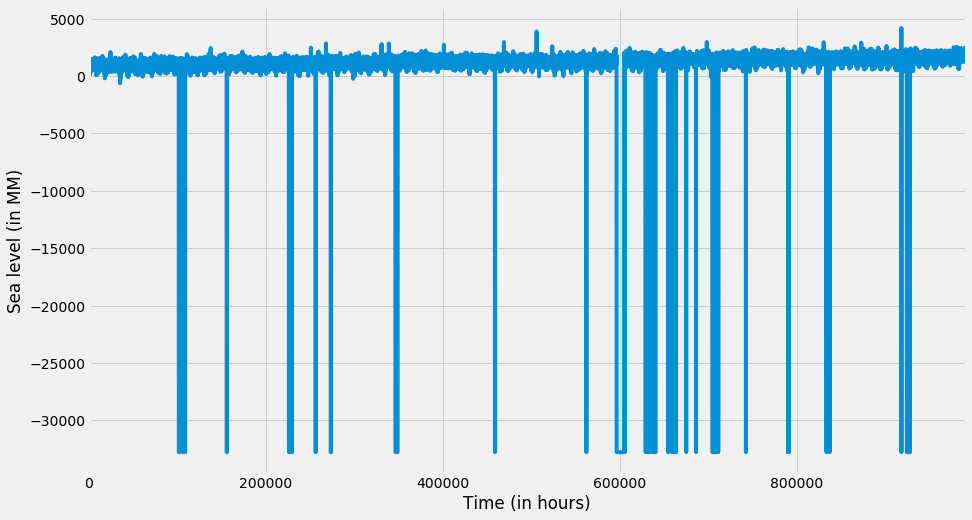

In [3]:
plt.figure(figsize=(14, 8))
dfSL['sealevel'].plot()
plt.xlabel('Time (in hours)')
plt.ylabel('Sea level (in MM)')
plt.show()

<br>

The long vertical lines in the above graph are telling us there are some missing values, so let's find them. Since the fill-in value is some negative small constant (which you can tell from the graph above) it is easy to find them. The following code will do the job:

In [4]:
fill_in = dfSL.loc[dfSL['sealevel']<-5000, "sealevel"].median()
print ('The fill in value is {0}'.format(fill_in))

The fill in value is -32767.0


<br>

Now, since we knew what is the fill-in value, we can drop all of them, and take a look at the data set again! (Note that the unit for the sea level is millimeters):

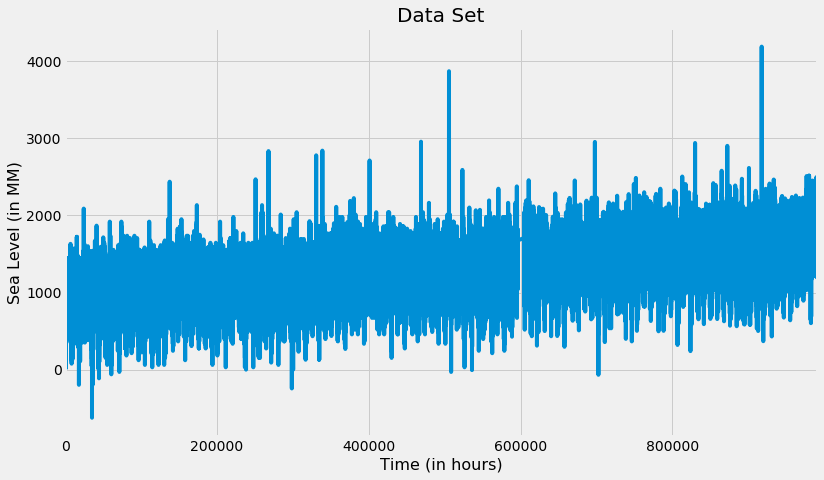

In [5]:
dfSL['sealevel'].replace(fill_in, np.nan, inplace=True)
dfSL.dropna(inplace= True)
plt.figure(figsize=(12, 7))
dfSL['sealevel'].plot()
plt.title('Data Set', fontsize=20)
plt.xlabel('Time (in hours)',  fontsize=16)
plt.ylabel('Sea Level (in MM)',  fontsize=16)
plt.show()

<br>

Before we extract the annual maxima sea level for each year, we have to find the years which are good enough to use. Why? Because if one particular year has a lot of missing data, the annual maximum sea level for that year is inaccurate! The threshold is we will only use the years where the number of missing values are less or equal to **10%** of that year.

In [6]:
n_hours = 365*24

sl_year = {}

for index, row in dfSL.iterrows():
    year = row['year']
    sl = row['sealevel']
    if year in sl_year:
        sl_year[year].append(sl)
    else:
        sl_year[year] = []
        sl_year[year].append(sl)
        
max_sl = {}

for year, sealevel in sl_year.items():
    if len(sealevel)/n_hours >= 0.9:
        max_sl[year] = max(np.array(sealevel)-np.mean(sealevel))

<br>

Now, we are ready to go! Let's take a look at the histogram of the annual maximum sea level at Galveston!

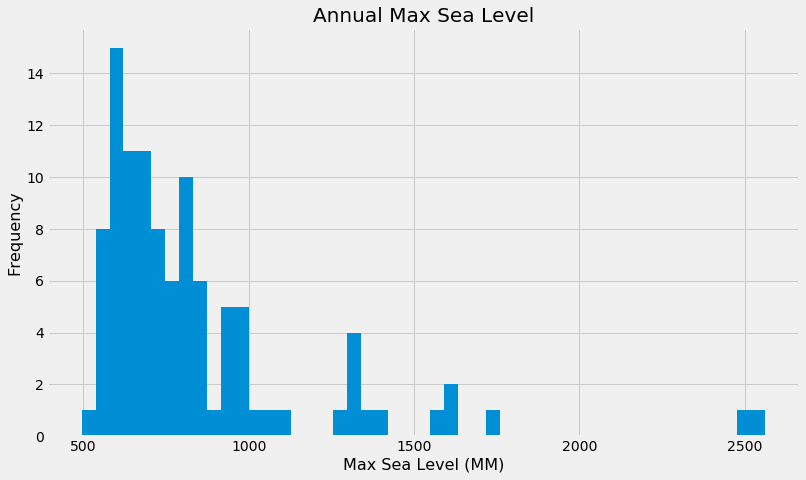

There are 103 years we can use


In [7]:
data_meas = list(max_sl.values())

plt.figure(figsize=(12, 7))
plt.hist(x=data_meas, bins=np.linspace(min(data_meas), max(data_meas)))
plt.title('Annual Max Sea Level', fontsize=20)
plt.xlabel('Max Sea Level (MM)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.show()
print ('There are {0} years we can use'.format(len(data_meas)))

<a id='log-likelihood'></a>
***
<h2 align="center">Log-Likelihood Function</h2>
[Back to top](#top)

<br>

Since we are dealing with GEV distribution again, we will use the same log-likelihood function from chapter 2B:

In [111]:
def loglikelihood(parameters, data_meas):
    mu, sigma, shape = parameters
    s = 0
    for i in range(len(data_meas)):
        logpdf = stats.genextreme.logpdf(x=data_meas[i], loc=mu, scale=sigma, c=shape)
        if logpdf == -np.inf:
            return -np.inf
        s += logpdf
    return s

***

<a id='log-prior'></a>
***
<h2 align="center">Log-Prior Distribution</h2>
[Back to top](#top)

<br>

Again the same log-prior distribution from chapter 2B!

In [116]:
def logprior(parameters):
    mu, sigma, shape = parameters
    mu_logpdf = stats.norm.logpdf(x=mu, loc=0, scale=1000)
    shape_logpdf = stats.norm.logpdf(x=shape, loc=0, scale=1000)
    if sigma >= 10000 or sigma <= 0:
        return -np.inf
    else:
        return mu_logpdf + np.log(1 / 10000) + shape_logpdf

***

<a id='log-posterior'></a>
***
<h2 align="center">Log-Posterior Distribution</h2>
[Back to top](#top)

In [122]:
def logpost(parameters, data_meas):
    pi = logprior(parameters)
    if pi == -np.inf:
        return -np.inf
    LL = loglikelihood(parameters, data_meas)
    return LL + pi

***

<a id='amha'></a>
***
<h2 align="center">Adaptive Metropolis-Hastings Algorithm</h2>
[Back to top](#top)

<br>

Same set up for Adaptive MCMC algorithm as Chapter 2B!

In [28]:
class State: 
    def __init__(self, state, value):
        self.state = state 
        self.value = value 

class ProblemMCMC: 
    def __init__(self, initial, logposterior, stepsize, data_meas, t, d):
        self.current = initial 
        self.logpost = logposterior 
        self.stepsize = stepsize 
        self.data_meas = data_meas
        self.t = t
        self.I_d = np.identity(d)
        self.S_d = (2.4)**2/d
        self.d = d
        
    def random_move(self, t, X):
        if (t <= self.t):
            next_move = stats.multivariate_normal.rvs(self.current.state, self.stepsize)
        else:
            cov = self.S_d*np.cov(X) + self.I_d*0.0001*self.S_d
            next_move = stats.multivariate_normal.rvs(self.current.state, cov)
        return next_move, self.logpost(next_move, self.data_meas)

In [29]:
def adaptivemcmc(problem, n_iter):
    parameters = []
    for i in range(problem.d):
        parameters.append([])
        parameters[i].append(problem.current.state[i])
    lpost = [problem.current.value]    
    n_accept = 0
    S = 0
    np.seterr(over='ignore')
    
    for t in range(n_iter):
        S += 1
        nextMove, nextValue = problem.random_move(t, parameters)
        delta_obj = np.exp(nextValue - lpost[-1])
        if delta_obj > 1:
            n_accept += 1
            for i in range(problem.d):
                parameters[i].append(nextMove[i])
            lpost.append(nextValue)
            problem.current.state = nextMove
            problem.current.value = nextValue
        else:
            p_accept = delta_obj
            accept = np.random.choice([True, False], p=[p_accept, 1-p_accept])
            if accept:
                n_accept += 1
                for i in range(problem.d):
                    parameters[i].append(nextMove[i])
                lpost.append(nextValue)
                problem.current.state = nextMove
                problem.current.value = nextValue
            else:
                for i in range(problem.d):
                    parameters[i].append(parameters[i][-1])
                lpost.append(lpost[-1])

    return (parameters, lpost, n_accept/S)

***

***
<h2 align="center">Gelman-Rubin Diagnostic</h2>

<br>

In [138]:
def GR_diag(parameter, interval=100, start=100):
    end = len(parameter[0])
    m = len(parameter)
    GR_result = []
    for n in range(start, end, interval):
        sequences = []
        for i in range(m):
            sequences.append(parameter[i][:n])
        GR_result.append(psrf(sequences))
    burnin = 0
    for i in range(len(GR_result)):
        if max(GR_result[i:]) < 1.1:
            burnin = i+1
            break
    return GR_result, burnin*interval

def psrf(sequences):
    u = [np.mean(sequence) for sequence in sequences]
    s = [np.var(sequence, ddof=1) for sequence in sequences]
    m = len(sequences)
    n = len(sequences[0])
    U = np.mean(u)
    B, W = 0, 0
    for i in range(m):
        B += (u[i] - U)**2
        W += s[i]
    B = (B*n)/(m-1)
    W = W/m
    Var = (1-(1/n))*W + (B/n)
    return np.sqrt(Var/W)

def GR_result(mcmc_chains, params, t, start=100, interval=100, plot=True):
    m, d, n = len(mcmc_chains), len(mcmc_chains[0]), len(mcmc_chains[0][0])
    params_raw, GR_params, burnin_params = [], [], []
    start, interval, end = start, interval, n
    for i in range(d):
        params_raw.append([])
        for j in range(m):
            params_raw[i].append(mcmc_chains[j][i])
    for i in range(d):
        GR, burnin = GR_diag(params_raw[i], interval, start)
        GR_params.append(GR)
        burnin_params.append(burnin)
    burnin = max(max(burnin_params), t)
    if plot:
        plt.figure(figsize=(14, 6))
        for i in range(d):
            plt.scatter(x=np.arange(start, end, interval), y=GR_params[i], label=params[i], color=COLORS[i % 3])
        plt.plot([burnin, burnin], plt.ylim(), label='burn in = {0}'.format(burnin))
        plt.xlabel('Iteration', fontsize=14)
        plt.ylabel('Potential Scale Reduction Fator', fontsize=14)
        plt.title('Gelman & Rubin Diagnostic', fontsize=14)
        plt.legend(loc='best')
        plt.show()
    return burnin

***

***
<h2 align="center">Auto Correlation Function</h2>

<br>

In [139]:
def ACF(X, end=200):
    N = len(X)
    acf = []
    for a in range(0, end):
        acf.append(np.corrcoef(X[a:], X[:N-a])[0][1])
        
    lag = -1
    for i in range(len(acf)):
        if acf[i] <= 0.05:
            lag = i
            break
    if lag == -1:
        print ('Please increase the value of the end parameter for this function')
    return lag, acf

def acf_result(mcmc_chains, params, burnin, plot=True):
    lag_params, acf_params = [], []
    m, d, n = len(mcmc_chains), len(mcmc_chains[0]), len(mcmc_chains[0][0])
    end = 100
    for i in range(d):
        lag_params.append([])
        acf_params.append([])
        for j in range(m):
            lag, acf = ACF(mcmc_chains[j][i][burnin:], end)
            lag_params[i].append(lag)
            acf_params[i].append(acf)
    lags = [max(np.array(lag_params)[:,i]) for i in range(m)]
    
    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=m, figsize=(25,6))
        for i in range(m):
            for j in range(d):
                ax[i].scatter(np.arange(0, end), acf_params[j][i], label=params[j], color=COLORS[j % 3])
                ax[i].fill_between(x=np.arange(0, end), y2=np.zeros_like(acf_params[j][i]), y1=acf_params[j][i], alpha=0.3, facecolor='skyblue')
            ax[i].plot([lags[i],lags[i]], ax[i].get_ylim(), label='lag = {0}'.format(lags[i]))
            ax[i].set_xlabel("Iag")
            ax[i].set_ylabel("ACF")
            ax[i].set_title("Sequence {0}".format(i+1))
            ax[i].legend(loc='best')
            ax[i].grid(alpha=0.5)
        plt.show()
    return lags

***

<a id='running-algo'></a>
***
<h2 align="center">Running the Algorithm</h2>
[Back to top](#top)

<br>

Finally, we can start the MCMC algorithm, We will generate 3 sequences each with 10000 iterations and start the adaption when iteration = 1000

In [135]:
def sequences_generator(m, n_iter, data_meas, logpost, d, t=1000, stepsize=[10, 2, 0.01]):
    np.seterr(divide='ignore', invalid='ignore')
    loc_est = np.median(data_meas)
    scale_est = (np.percentile(data_meas, 75) - np.percentile(data_meas, 25))/2
    shape_est = 0
    gevfit = stats.genextreme.fit(data_meas, loc=loc_est, scale=scale_est)
    
    if logpost([gevfit[1], gevfit[2], gevfit[0]], data_meas) > -np.inf:
        loc_est, scale_est, shape_est = gevfit[1], gevfit[2], gevfit[0]
        
    elif logpost([loc_est, scale_est, -0.1], data_meas) > -np.inf:
        loc_est, scale_est, shape_est = loc_est, scale_est, -0.1
        
    elif logpost([loc_est, scale_est, 0.1], data_meas) > -np.inf:
        loc_est, scale_est, shape_est = loc_est, scale_est, 0.1
        
    else:
        loc_est, scale_est, shape_est = loc_est, scale_est, 0
        
    problems = []
    for i in range(m):
        ui = np.random.randint(low=loc_est, high=loc_est+100)
        si = np.random.randint(low=scale_est, high=scale_est+100)
        shapei = shape_est
        theta =[ui, si, shapei]
        state = State(theta, logpost(theta, data_meas))
        problems.append(ProblemMCMC(state, logpost, stepsize, data_meas, t, d))
    ar, mcmc_chains, ls = [], [], []
    for i in range(m):
        parameters, l, r = adaptivemcmc(problems[i], n_iter)
        mcmc_chains.append(parameters)
        ar.append(r)
        ls.append(l)
    return mcmc_chains, ar, ls

In [32]:
t=1000
mcmc_chains, ar, ls = sequences_generator(m=3, n_iter=10000, t=t, d=3, logpost=logpost, data_meas=data_meas)

***

<a id='history-plots'></a>
***
<h2 align="center">History plots for each parameter</h2>
[Back to top](#top)

<br>

In [33]:
def history_plots(mcmc_chains, params, true_params=None):
    m = len(mcmc_chains)
    fig, ax = plt.subplots(nrows=1, ncols=len(params), figsize=(16, 6))
    fig.suptitle("History Plots", fontsize=20)
    for i in range(len(params)):
        for j in range(m):
            ax[i].plot(
                mcmc_chains[j][i],
                label="Sequence {0}".format(j + 1),
                color=COLORS[j % 3],
                alpha=ALPHAS[j % 3],
            )
        if true_params is not None:
            ax[i].plot(
                ax[i].get_xbound(),
                [true_params[i], true_params[i]],
                color="black",
                linestyle="dashed",
                label=params[i] + " true value",
                linewidth=2.5,
            )
        ax[i].set_xlabel("Iteration", fontsize=16)
        ax[i].set_ylabel(params[i] + " Trace", fontsize=16)
        ax[i].legend(loc="best")
    plt.show()

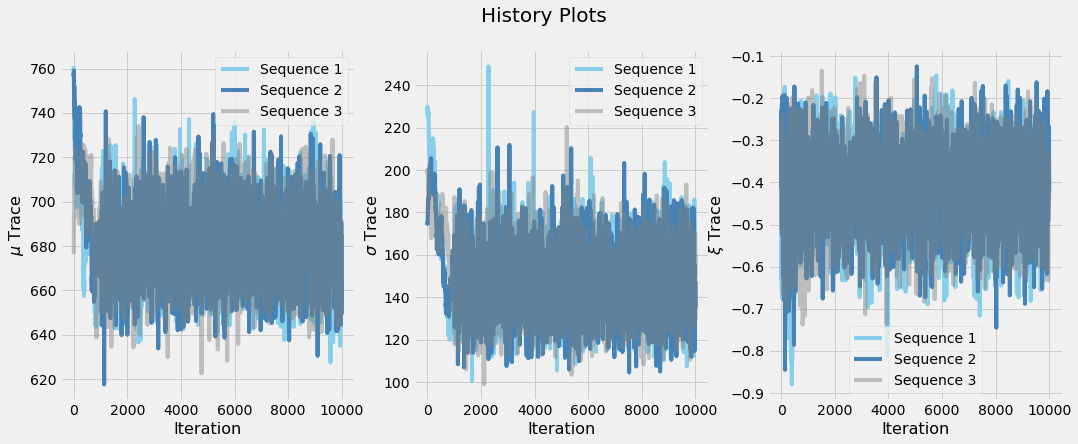

In [34]:
history_plots(mcmc_chains, [r"$\mu$", r"$\sigma$", r"$\xi$"])

***

<a id='gr-diagnostic'></a>
***
<h2 align="center">Gelman-Rubin Diagnostic Results</h2>
[Back to top](#top)

<br>

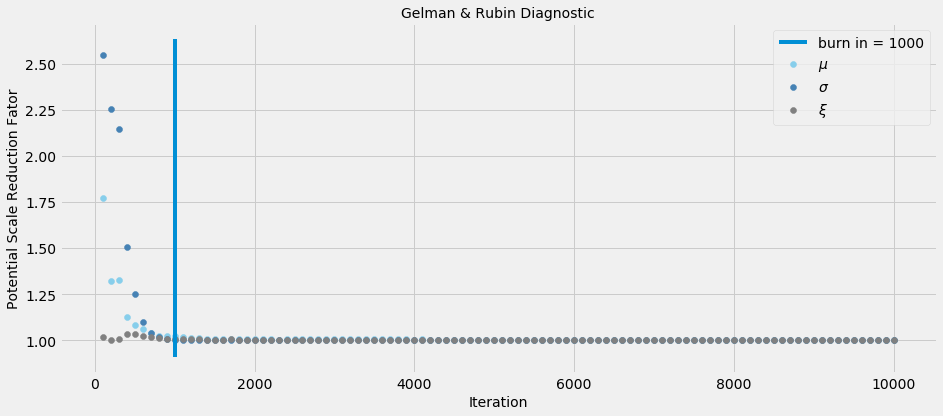

1000

In [130]:
burnin = GR_result(mcmc_chains, [r"$\mu$", r"$\sigma$", r"$\xi$"], t)

***

<a id='ac-function'></a>
***
<h2 align="center">Auto Correlation Function Results</h2>
[Back to top](#top)

<br>

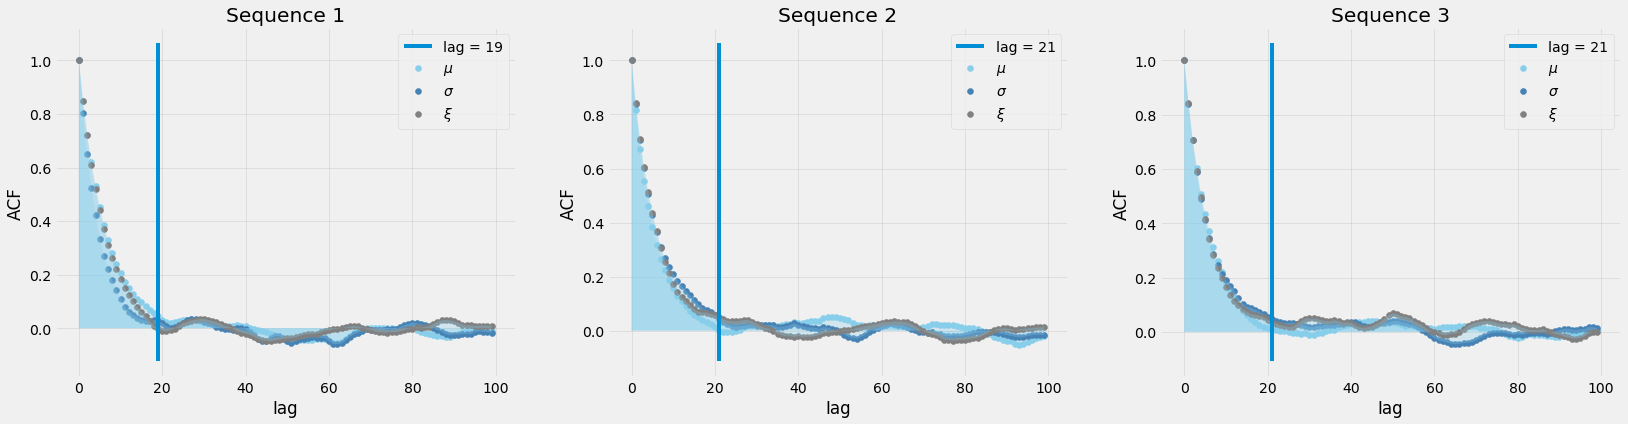

In [128]:
lags = acf_result(mcmc_chains, [r"$\mu$", r"$\sigma$", r"$\xi$"], burnin)

***

<a id='histograms'></a>
***
<h2 align="center">Histograms For Each Parameter</h2>
[Back to top](#top)

<br>

In [123]:
def final_params_pool(mcmc_chains, burnin, lags, params, plot=True):
    m, d, n = len(mcmc_chains), len(mcmc_chains[0]), len(mcmc_chains[0][0])
    params_pool, params_ana = [], [[] for i in range(d)]
    for i in range(m):
        for j in range(burnin, n, lags[i]):
            params_pool.append([])
            for k in range(d):
                params_ana[k].append(mcmc_chains[i][k][j])
                params_pool[-1].append(mcmc_chains[i][k][j])
            
    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=d, figsize=(16,6))
        for i in range(d):
            ax[i].hist(params_ana[i], color="steelblue")
            ax[i].set_xlabel(params[i])
            ax[i].set_ylabel("Frequency")
            ax[i].grid(alpha=0.5)
        plt.show()  
    return params_pool

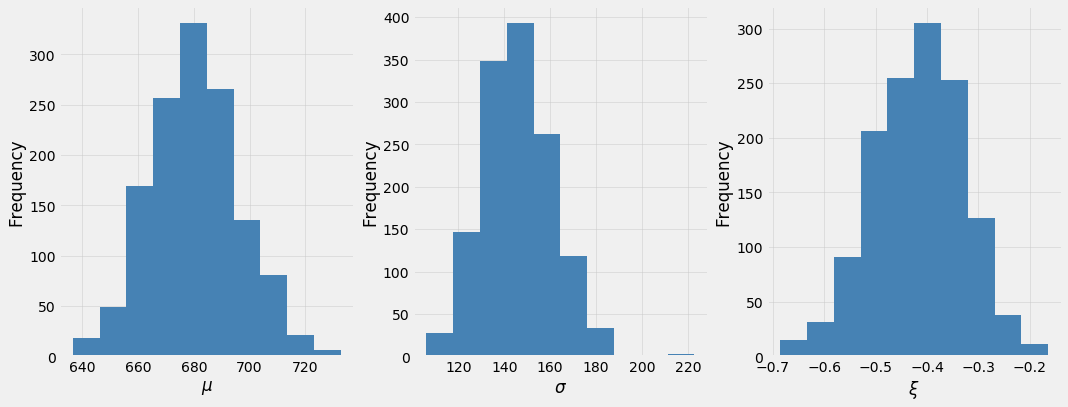

In [124]:
params_analysis = final_params_pool(mcmc_chains, burnin, lags, [r"$\mu$", r"$\sigma$", r"$\xi$"])

***

<a id='max-ls'></a>
***
<h2 align="center">Max Log-Posterior Score Parameter Set</h2>
[Back to top](#top)

<br>

In [133]:
def max_ls_parameters(ls, mcmc_chains):
    max_indices = []
    maxs = []
    for i in range(len(mcmc_chains)):
        max_indices.append(np.where(np.array(ls[i]) == np.array(ls[i]).max())[0][0])
        maxs.append(np.array(ls[i]).max())
    seqi = np.where(np.array(maxs) == np.array(maxs).max())[0][0]
    iterj = max_indices[seqi]
    max_params = []
    d = len(mcmc_chains[0])
    for i in range(d):
        max_params.append(mcmc_chains[seqi][i][iterj])
    print ('The parameters with max log-posterior score are',max_params)
    return max_params

In [134]:
max_params = max_ls_parameters(ls, mcmc_chains)

The parameters with max log-posterior score are [676.7982590360125, 137.78431771842, -0.41980487332283245]


***

<a id='diag-plots'></a>
***
<h2 align="center">Diagnostic Plots</h2>
[Back to top](#top)

<br>

In [101]:
RP = np.arange(1, 501, 1)
RL = []
RL_max = []
percentile_95 = []
percentile_5 = []
percentile_995 = []
percentile_05 = []
for i in range(len(RP)):
    RL.append([])
    RL_max.append(stats.genextreme.ppf(q=(1-1/RP[i]), c=max_params[2], loc=max_params[0], scale=max_params[1]))
    for j in range(len(params_analysis)):
        RL[i].append(stats.genextreme.ppf(q=(1-1/RP[i]), c=params_analysis[j][2], loc=params_analysis[j][0], scale=params_analysis[j][1]))
for i in range(len(RL)):
    percentile_95.append(np.percentile((RL[i]), 95))
    percentile_5.append(np.percentile((RL[i]), 5))
    percentile_995.append(np.percentile((RL[i]), 99.5))
    percentile_05.append(np.percentile((RL[i]), 0.5))
    
empirical = [stats.genextreme.ppf(q=(i+1)/(len(data_meas)+1), c=max_params[2], loc=max_params[0], scale=max_params[1]) for i in range(len(data_meas))]
cdf = [stats.genextreme.cdf(x=np.sort(data_meas)[i], c=max_params[2], loc=max_params[0], scale=max_params[1]) for i in range(len(data_meas))]
x_range = np.arange(0, max(data_meas)+1, 0.5)
y_range = [stats.genextreme.pdf(x=xi, c=max_params[2], loc=max_params[0], scale=max_params[1]) for xi in x_range]

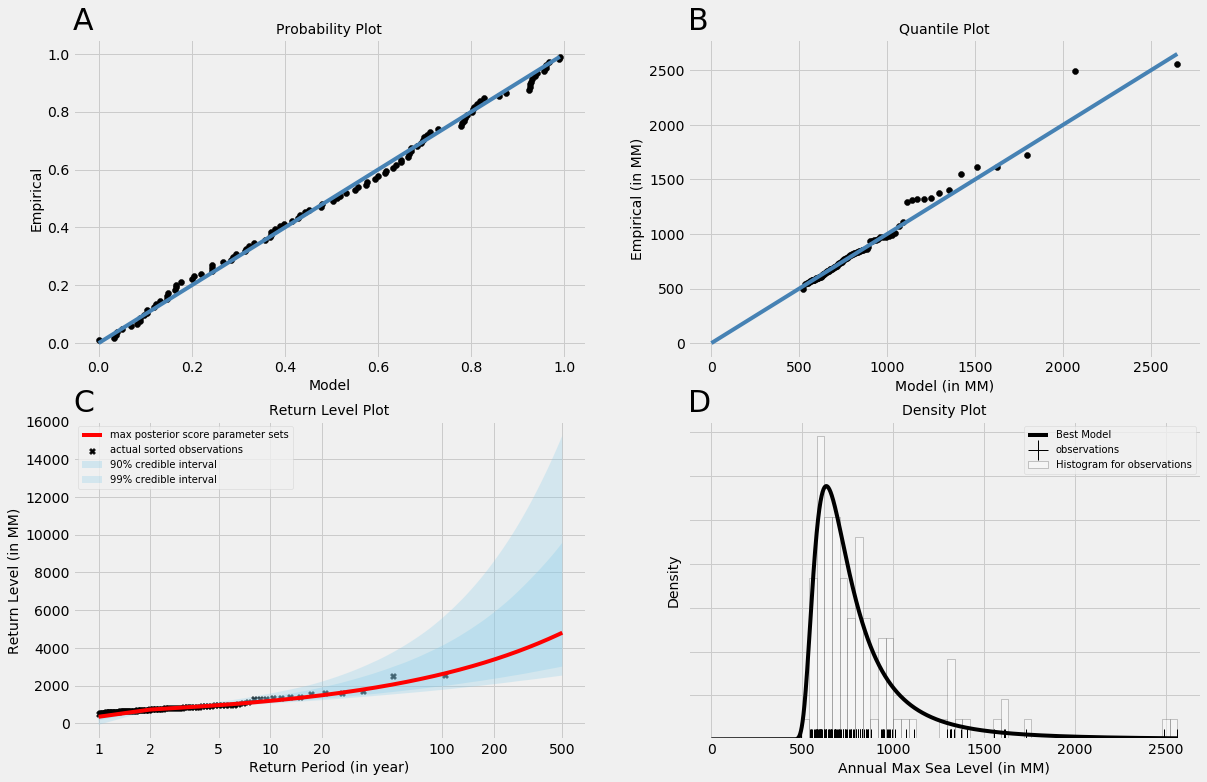

In [102]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

ax[0,0].scatter(cdf, [(i+1)/(len(data_meas)+1) for i in range(len(data_meas))], color='black')
ax[0,0].plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), color='steelblue')
ax[0,0].set_title('Probability Plot', fontsize=14)
ax[0,0].set_xlabel('Model', fontsize=14)
ax[0,0].set_ylabel('Empirical', fontsize=14)
ax[0,0].annotate("A", xy=(0.0, 1.03), xycoords="axes fraction", fontsize=30)

ax[0,1].scatter(empirical, np.sort(data_meas), color='black')
ax[0,1].plot(np.arange(0, max(empirical)), np.arange(0, max(empirical)), color='steelblue')
ax[0,1].set_title('Quantile Plot', fontsize=14)
ax[0,1].set_xlabel('Model (in MM)', fontsize=14)
ax[0,1].set_ylabel('Empirical (in MM)', fontsize=14)
ax[0,1].annotate("B", xy=(0.0, 1.03), xycoords="axes fraction", fontsize=30)

ax[1,0].plot(np.log10(RP), RL_max, color='r', label='max posterior score parameter sets')
ax[1,0].scatter(np.log10([(len(data_meas)+1)/(len(data_meas)+1-k) for k in np.arange(1, len(data_meas)+1, 1)]), np.sort(data_meas), label='actual sorted observations', color='black', marker='X')
ax[1,0].fill_between(x=np.log10(RP), y1=percentile_95, y2=percentile_5, alpha=0.3, label='90% credible interval', facecolor='skyblue')
ax[1,0].fill_between(x=np.log10(RP), y1=percentile_995, y2=percentile_05, alpha=0.27, label='99% credible interval', facecolor='skyblue')
ax[1,0].legend(loc='upper left', fontsize=10)
ax[1,0].set_xticks(np.log10([1,2,5,10,20,100,200,500]))
ax[1,0].set_xticklabels([1,2,5,10,20,100,200,500])
ax[1,0].set_title('Return Level Plot', fontsize=14)
ax[1,0].set_xlabel('Return Period (in year)', fontsize=14)
ax[1,0].set_ylabel('Return Level (in MM)', fontsize=14)
ax[1,0].annotate("C", xy=(0.0, 1.03), xycoords="axes fraction", fontsize=30)

ax[1,1].hist(data_meas, bins=np.linspace(min(data_meas), max(data_meas)), normed=True, edgecolor='black', label='Histogram for observations', color='white', alpha=0.4)
ax[1,1].plot(x_range, y_range, label='Best Model', color='black')
ax[1,1].plot(data_meas, np.zeros_like(data_meas), 'b+', ms=20, color='black', label='observations')
ax[1,1].legend(loc='best', fontsize=10)
ax[1,1].set_yticklabels([])
ax[1,1].set_title('Density Plot', fontsize=14)
ax[1,1].set_xlabel('Annual Max Sea Level (in MM)', fontsize=14)
ax[1,1].set_ylabel('Density', fontsize=14)
ax[1,1].annotate("D", xy=(0.0, 1.03), xycoords="axes fraction", fontsize=30)

plt.show()